In [31]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 27927), started 0:00:03 ago. (Use '!kill 27927' to kill it.)

#### Loading the relevant datasets (15/100)

dataframe shape:
(15026, 4)

dataframe shape:
(4696, 4)

dataframe shape:
(3757, 4)

['age' 'ethnicity' 'gender' 'img_name']
Train Gender Distribution:
0    0.52336
1    0.47664
Name: gender, dtype: float64

Test Gender Distribution:
0    0.522998
1    0.477002
Name: gender, dtype: float64

Val Gender Distribution:
0    0.523024
1    0.476976
Name: gender, dtype: float64

Train Ethnicity Distribution:
0    0.424065
1    0.190936
3    0.167976
2    0.145481
4    0.071543
Name: ethnicity, dtype: float64

Test Eethnicity Distribution:
0    0.423978
1    0.190801
3    0.168228
2    0.145443
4    0.071550
Name: ethnicity, dtype: float64

Val Eethnicity Distribution:
0    0.424009
1    0.190844
3    0.168219
2    0.145595
4    0.071334
Name: ethnicity, dtype: float64



<AxesSubplot:>

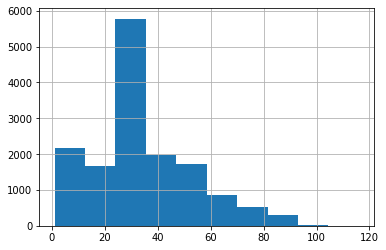

In [3]:
# load the datasets using the csv files train, val and test (3)
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
val = pd.read_csv('./data/val.csv')

# print the shapes of the dataframes 
# (3)
print(f"dataframe shape:\n{train.shape}\n")
print(f"dataframe shape:\n{test.shape}\n")
print(f"dataframe shape:\n{val.shape}\n")

# print the column names from either one of the dataframes 
# (1)
print(train.columns.values)

# print the proportional distribution of gender in all three datasets(i.e., number of male and female) 
# (3)
print(f"Train Gender Distribution:\n{train['gender'].value_counts() / len(train)}\n")
print(f"Test Gender Distribution:\n{test['gender'].value_counts() / len(test)}\n")
print(f"Val Gender Distribution:\n{val['gender'].value_counts() / len(val)}\n")

# print the proportional distribution of ethnicity in all three datasets 
# (3)
print(f"Train Ethnicity Distribution:\n{train['ethnicity'].value_counts() / len(train)}\n")
print(f"Test Eethnicity Distribution:\n{test['ethnicity'].value_counts() / len(test)}\n")
print(f"Val Eethnicity Distribution:\n{val['ethnicity'].value_counts() / len(val)}\n")

# plot the age distribution from the training dataset where the x-axis plots the age and the y-axis depicts the count of individuals within each age group. For example, individuals with age=1 are: 
# (2)

train['age'].hist()

In [4]:
def make_directories():
    d = datetime.datetime.today()
    timestamp = d.strftime('%Y%m%d_%H%M%S')
    # folder to store the tensorboard logs
    tensorlog_folder = os.path.join(os.path.curdir, 'logs', timestamp)
    # folder to store the trained models
    checkpoint_folder = os.path.join(os.path.curdir, 'models', timestamp)

    os.mkdir(tensorlog_folder)
    os.mkdir(checkpoint_folder)

    return checkpoint_folder, tensorlog_folder

#### Create the ImageDataGenerators (22/100)

Found 15026 validated image filenames.
Found 3757 validated image filenames.
Found 4696 validated image filenames.
2
3
1


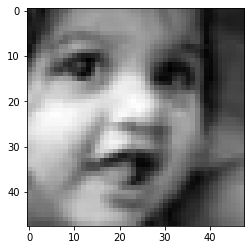

In [10]:
# # ImageDataGenerator is an iterator.

# # specify the batch size hyperparameter. You can experiment with different batch sizes
batch_size = 16

# # create the ImageDataGenerator with rescaling that will generate batched tensors representing images with real-time data augmentation
# # use at least two of the augmentation strategies. For example, fill_mode='nearest'
# # please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# # (3)

train_img_gen = ImageDataGenerator(
  fill_mode='nearest',
  horizontal_flip=True,
  rescale=1./255
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance to link the image folder and the dataframe.
# also include the, batch size, image size and the seed.
# make sure to include the following arguments
# color_mode='grayscale', class_mode='multi_output'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (5)
# TODO
train_generator = train_img_gen.flow_from_dataframe(
  dataframe=train,
  directory='./data/images/train',
  x_col='img_name',
  y_col=['age','ethnicity','gender'],
  class_mode='multi_output',
  color_mode='grayscale',
  batch_size=batch_size,
  seed=SEED,
  target_size=(48,48)
)



# similarly, create an ImageDataGenerator for the validation dataset and make sure not to use any of the augmentation strategies except rescaling the image
# (2)
val_img_gen = ImageDataGenerator(
  rescale=1./255
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance with the same arguments as above
# make sure to specify the following arguments:
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
# TODO
val_generator = val_img_gen.flow_from_dataframe(
  dataframe=val,
  directory='./data/images/val',
  x_col='img_name',
  y_col=['age','ethnicity','gender'],
  class_mode='multi_output',
  color_mode='grayscale',
  batch_size=batch_size,
  seed=SEED,
  target_size=(48,48),
  shuffle=False
)

# use the method "flow_from_dataframe" from the val_img_gen instance to link the test dataframe and the test data folder
# In addition, make sure to specify the following arguments
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
# TODO

test_generator = val_img_gen.flow_from_dataframe(
  dataframe=test,
  directory='./data/images/test/',
  x_col='img_name',
  y_col=['age','ethnicity','gender'],
  class_mode='multi_output',
  color_mode='grayscale',
  batch_size=batch_size,
  seed=SEED,
  target_size=(48,48),
  shuffle=False
)


# enumerate through the validation data generator created above and plot first grayscale image 
# (2)
for i, element in enumerate(val_generator):
    if i == 0:
      print(element[1][0][i])
      print(element[1][1][i])
      print(element[1][2][i])
      plt.imshow(element[0][i], cmap = 'gray')
      break

#### Create the model (44/100)

In [36]:
# specify the model input with the required shape 
# (1)
# TODO
input = keras.Input(shape=(48, 48, 1))

# The shared layers
# Include at least one Conv2D layer, MaxPooling2D layer and a Flatten layer
# you can have as many layers as possible, but make sure not to overfit your model using the training data
# TODO
# (10)

layer1 = tf.keras.layers.Conv2D(16, (2,2), activation= 'relu', name="layer1")
layer2 = tf.keras.layers.MaxPool2D(2,2, name="layer2")
layer3 = tf.keras.layers.Flatten(name="layer3")
layer4 = tf.keras.layers.Dense(64, activation='relu', name='layer4')
layer5 = tf.keras.layers.Dense(128, activation='relu', name='layer5')

sharedLayers = layer5(layer4(layer3(layer2(layer1(input)))))

# Task specific layers
# Include at least one Dense layer as a task specific layer before generating the output for age
# TODO
# (2)
ageTaskSpecificLayer = tf.keras.layers.Dense(128, activation='relu', name='age_task')


# Include the age output and make sure to include the following arguments
# activation='linear', name='xxx'(any name)
# make sure to name your output layers so that different metrics to be used can be linked accordingly
# please note that the age prediction is a regression task
# TODO
# (2)
ageLayer = tf.keras.layers.Dense(120, activation='linear', name='age')
ageOutput = ageLayer(ageTaskSpecificLayer(sharedLayers))

# Similar to above, specify one or more Dense layers as task specific layers for ethnicity prediction
# TODO
# (2)

ethnicityTaskSpecificLayer1 = tf.keras.layers.Dense(128, activation='relu', name='eth_task1')
ethnicityTaskSpecificLayer2 = tf.keras.layers.Dense(256, activation='relu', name='eth_task2')

# Include the ethnicity output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a multi-class classification task
# TODO
# (2)
ethnicityLayer = tf.keras.layers.Dense(5, activation='sigmoid', name='ethnicity')
ethnicityOutput = ethnicityLayer(ethnicityTaskSpecificLayer2(ethnicityTaskSpecificLayer1((sharedLayers))))

# Similar to above, specify one or more Dense layers as task specific layers for gender prediction
# TODO
# (2)

genderTaskSpecificLayer1 = tf.keras.layers.Dense(128, activation='relu', name='gender_task1')
genderTaskSpecificLayer2 = tf.keras.layers.Dense(256, activation='relu', name='gender_task2')

# Include the gender output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a binary classification task
# TODO
# (2)

genderLayer = tf.keras.layers.Dense(2, activation='sigmoid', name='gender')

genderOutput = genderLayer(genderTaskSpecificLayer2(genderTaskSpecificLayer1(sharedLayers)))

# create the model with the required input and the outputs.
# pelase make sure that the outputs can be included in a list and make sure to keep note of the order
# TODO
# (3)

outputs = [ageOutput, ethnicityOutput, genderOutput]
model = tf.keras.Model(inputs=input, outputs=outputs, name="Logan")

# print the model summary
# TODO
# (0.5)

print(model.summary())
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

# Instantiate the optimizer with the learning rate. You can start with the learning rate 1e-3(0.001).
# Both the optimizer and the learning rate are hyperparameters that you can finetune
# For example, you can start with the "RMSprop" optimizer
# TODO
# (2)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# specify the losses to be used for each task: age, ethnicity and gender prediction 
# (0.5)
losses = {'age':tf.keras.losses.SparseCategoricalCrossentropy(), 'gen':tf.keras.losses.KLDivergence(), 'eth':tf.keras.losses.SparseCategoricalCrossentropy()},

# compile the model with the optimizer, loss, loss_weights and the metrics for each task
# apply the following weights to the losses to balance the contribution of each loss to the total loss
# loss_weights=[0.001, 0.5, 0.5]
# please remember to use the relevant metric for each task by assigning it to the correct output
# TODO
# (2)
model.compile(optimizer=optimizer,
              loss=losses,
              loss_weights=[0.001, 0.5, 0.5],
              metrics={'age': 'mean_absolute_error', 'ethnicity': ['accuracy'],'gender':['accuracy']}
              )

check_dir, tboard_dir = make_directories()
# Define the callbacks
# EarlyStopping: monitor the validation loss while waiting for 3 epochs before stopping
# can restore the best weights
# TODO
# (2)
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


# ModelCheckpoint
# monitor validation loss and save the best model weights
# TODO
# (2)
checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=check_dir,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Initiallize TensorBoard
# TODO
# (2)

tensorboard = keras.callbacks.TensorBoard(
    log_dir=tboard_dir
)

# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
# TODO
# (2)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

callbacks = [early_stop, checkpoints, tensorboard, reduce_lr]

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)

model.fit(
        train_generator,
        epochs=15,
        validation_data=val_generator,
        batch_size=batch_size, 
        callbacks=callbacks,
        steps_per_epoch=len(train)/batch_size,
        validation_steps=len(val)/batch_size)


Model: "Logan"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 layer1 (Conv2D)                (None, 47, 47, 16)   80          ['input_12[0][0]']               
                                                                                                  
 layer2 (MaxPooling2D)          (None, 23, 23, 16)   0           ['layer1[0][0]']                 
                                                                                                  
 layer3 (Flatten)               (None, 8464)         0           ['layer2[0][0]']                 
                                                                                              

#### Making predictions on test data (14/100)

In [37]:
# evaluate the trained model using the test generator
# print only the test accuracy for ethnicity and gender predictions
(4)
result = model.evaluate(test_generator)
results = dict(zip(model.metrics_names, result))
print("Ethnicity Accuracy:", results['ethnicity_accuracy'])
print("Gender Accuracy:", results['gender_accuracy'])


294/294 [==============================] - 3s 11ms/step - loss: 0.3823 - age_loss: 4.7875 - ethnicity_loss: 0.7551 - gender_loss: -1.6859e-06 - age_mean_absolute_error: 33.5517 - ethnicity_accuracy: 0.7530 - gender_accuracy: 0.5230
Ethnicity Accuracy: 0.7529812455177307
Gender Accuracy: 0.5229982733726501


In [27]:
# generate predictions using the test generator
# (2)
predictions = model.predict(test_generator)

# extract the ethnicity predictions
# (2)
print(predictions[0][0])
print(predictions[0][1])
print(predictions[0][2])
# print the classification report for predicting ethnicity
# (2)

# extract the gender predictions where probabilities above 0.5 are considered class 1 and if not, class 0
# (2)
# print the classification report for predicting gender
# (2)

[-0.47965768 -0.12089835 -0.2780912  -0.4052349  -0.7223268  -0.44004974
 -0.26274312 -1.788492   -0.54881734 -0.3117617  -0.64327425 -1.000211
 -0.28101707 -0.37874588 -0.63461244 -0.66138774 -0.47870862 -1.446407
 -1.4984896  -1.4789258  -0.4870478  -0.5681696  -0.3038477  -1.2768476
 -0.5677314  -1.0138271  -1.2209941  -0.34288642 -0.33299237 -2.1903634
 -1.0802695  -0.3681637  -1.1208776  -1.2532543  -1.0709677  -0.5113333
 -0.37983063 -0.35918576 -0.3175752  -0.7786218  -0.38187486 -0.7141692
 -1.6375712  -0.69703346 -0.46615645 -0.4783179  -1.1657577  -0.94291365
 -0.57105494 -1.3662281  -0.36535558 -0.979627   -0.81696063 -0.4919121
 -0.2522089  -0.6832323  -0.5029743  -0.7516299  -1.1504604  -0.8415222
 -0.29093444 -1.3925811  -0.4093887  -1.096651   -0.6056338  -1.0004513
 -0.80250156 -1.5643778  -0.21088518 -0.79474854 -0.802493   -0.35731876
 -0.5567272  -1.0767713  -0.9115688  -0.8795783  -1.0287929  -0.656565
 -0.39760298 -1.8353024  -1.1510475  -1.0951055  -0.62479305 -0.

#### Present prediction results on test data(5/100)

Present your findings for 5 different runs by fine-tuning the hyperparameters. The results table must contain the following fields
- A minimum of 5 hyperparameters that you have fine-tuned
- Mean absolute error for age
- Accuracy for ethnicity prediction
- Accuracy for gender prediction
Please use a table format similar to the one mentioned below when presenting the results.

| Hyperparameters | Age(MAE) | Ethnicity(Accuracy)| Gender(Accuracy) |
|-----------------|----------|--------------------|------------------|
|  Default params |     34   |       %41          |     51%          |
| Ethnicity output activation -> sigmoid | 34| %75|     51%          |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
